In [2]:
import h5py

In [266]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof
import numpy as np
import os

In [19]:
print(tf.__version__)

2.18.0


In [200]:
def GetSize(aPath, unit="KB"):
    lNrOfBytes = os.path.getsize(aPath)
    if(unit == "KB"):
       return round(lNrOfBytes / 1024, 4);
    elif(unit == "MB"):
        return round(lNrOfBytes / (1024 * 1024), 4)
    else:
        print("Unknown measurement unit")
        return 0

In [185]:
def print_in_out_info(aInterpreter):
    print("Input details:")
    print(aInterpreter.get_input_details())
    print("Output details:")
    print(aInterpreter.get_output_details())

In [ ]:
class Runner(object):
    def __init__(self, aKerasModel):
        self.mKerasModel = aKerasModel
        self.mTfLiteModel = None
        self.TF_MODEL_PATH = "./mnist_tf_model.tflite"
        self.TF_MODEL_FP16_PATH = "./mnist_tf_fp16_model.tflite"
        self.TF_MODEL_INT8_PATH = "./mnist_tf_int8_model.tflite"

    @staticmethod
    def GetSize(aPath, unit="KB"):
        lNrOfBytes = os.path.getsize(aPath)
        if(unit == "KB"):
           return round(lNrOfBytes / 1024, 4);
        elif(unit == "MB"):
            return round(lNrOfBytes / (1024 * 1024), 4)
        else:
            print("Unknown measurement unit")
            return 0
    
    def Run(self, aTestImages, aTestLabels):
        _, lAcc = self.mKerasModel.evaluate(aTestImages, aTestLabels, verbose=2)
        print("Accuracy of keras model: {}%".format(round(lAcc*100,2)))
        
    def RunTfLite(self, aTestImages, aTestLabels, dt="FP32"):
        lTfLiteConverter = tf.lite.TFLiteConverter.from_keras_model(self.mKerasModel)
        lTfLiteModelPath = self.TF_MODEL_PATH;
        if(dt == "FP16"):
            lTfLiteConverter.optimizations = [tf.lite.Optimize.DEFAULT]
            lTfLiteConverter.target_spec.supported_types = [tf.float16]
            lTfLiteModelPath = self.TF_MODEL_FP16_PATH;
        elif(dt == "INT8"):
            lTfLiteConverter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
            lTfLiteModelPath = self.TF_MODEL_INT8_PATH;
        else:
            print("Unknown data type provided")
       
        self.mTfLiteModel = lTfLiteConverter.convert()
        if(self.mTfLiteModel is not None):
            lFd = open(lTfLiteModelPath, mode="wb")
            lNrOfBytesWritten = lFd.write(self.mTfLiteModel)
            assert(lNrOfBytesWritten == len(self.mTfLiteModel))
        
        lTfLiteInterpreter = tf.lite.Interpreter(model_path=lTfLiteModelPath)
        lTfLiteInterpreter.resize_tensor_input(input_index=in_details[0]["index"], tensor_size=(10000,28,28))
        lTfLiteInterpreter.resize_tensor_input(input_index=out_details[0]["index"], tensor_size=(10000,10))
        lTfLiteInterpreter.allocate_tensors()

        lTestImagesFp32 = np.float32(aTestImages)
        lInDetails = lTfLiteInterpreter.get_input_details()
        lOutDetails = lTfLiteInterpreter.get_output_details()
        lTfLiteInterpreter.set_tensor(lInDetails[0]["index"], lTestImagesFp32)
        lTfLiteInterpreter.invoke()
        lYValues = lTfLiteInterpreter.tensor(lOutDetails[0]["index"])()
        lPred = np.argmax(lYValues, axis=1)
        lAccScore = accuracy_score(aTestLabels, lPred)

        print("Accuracy score for tflite model with size {} is {}%".format(round(GetSize(lTfLiteModelPath),2), round(100*lAccScore,2)))

    def RunModel(self, aTestImages, aTestLabels, dt="FP64"):
        if(dt == "FP64"):
            _, lAcc = self.mKerasModel.evaluate(aTestImages, aTestLabels, verbose=2)
            print("Accuracy of keras model: {}%".format(round(lAcc*100,2)))
        elif(dt == "FP32"):
            RunTfLite(aTestImages, aTestLabels)
        elif(dt == "FP16"):
            RunTfLite(aTestImages, aTestLabels, "FP16")
        elif(dt == "INT8"):
            RunTfLite(aTestImages, aTestLabels, "INT8")
        else:
            print("Unknown data type provided!")

        

In [233]:
dataset = keras.datasets.fashion_mnist

In [208]:
(x_train,y_train),  (x_test, y_test) = dataset.load_data();

In [209]:
print(x_train.shape, x_train.dtype)

(60000, 28, 28) uint8


In [210]:
print(y_train.shape, y_train.dtype)

(60000,) uint8


In [211]:
len(x_train)

60000

In [212]:
unique_y_train = np.unique(y_train)

In [213]:
print(unique_y_train)

[0 1 2 3 4 5 6 7 8 9]


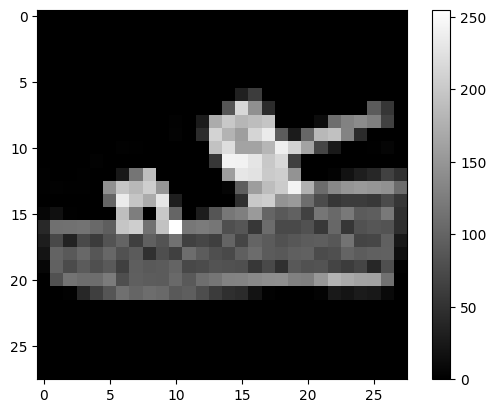

In [214]:
plt.figure()
plt.imshow(x_train[12], cmap="gray")
plt.colorbar()
plt.grid(False)
plt.show()

In [215]:
x_train = x_train / 256
x_test = x_test / 256

In [279]:
model = keras.Sequential([keras.layers.Input(shape=(28,28)), 
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation="relu"),
                          keras.layers.Dropout(rate=0.20),
                          keras.layers.Dense(128, activation="relu"),
                          keras.layers.Dense(10)])

In [280]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

In [282]:
model.compile(optimizer="adam", loss=SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(x=x_train, y=y_train, epochs=30)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 607us/step - accuracy: 0.8950 - loss: 0.2823
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - accuracy: 0.8967 - loss: 0.2748
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step - accuracy: 0.8979 - loss: 0.2708
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - accuracy: 0.8998 - loss: 0.2689
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - accuracy: 0.9008 - loss: 0.2644
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - accuracy: 0.9014 - loss: 0.2598
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - accuracy: 0.9065 - loss: 0.2493
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - accuracy: 0.9068 - loss: 0.2473
Epoch 9/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - accuracy: 0.9104 - loss: 0.2404
Epoch 10/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.9099 - loss: 0.2363
Epoch 11/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step - accuracy: 0.9103 - loss: 0.2364
Epoch 12

In [274]:
r = Runner(model)
r.Run(x_test, y_test)

313/313 - 0s - 451us/step - accuracy: 0.8932 - loss: 0.3410
Accuracy of keras model: 89.32%


In [275]:
r.RunTfLite(x_test, y_test)

Unknown data type provided
INFO:tensorflow:Assets written to: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpq_1ogmpb/assets


INFO:tensorflow:Assets written to: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpq_1ogmpb/assets


Saved artifact at '/var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpq_1ogmpb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  14122799120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14122801232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14122801616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14122802192: TensorSpec(shape=(), dtype=tf.resource, name=None)
Accuracy score for tflite model with size 399.25 is 89.32%


W0000 00:00:1741083813.122055 115173051 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1741083813.122065 115173051 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-04 12:23:33.122139: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpq_1ogmpb
2025-03-04 12:23:33.122283: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-04 12:23:33.122287: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpq_1ogmpb
2025-03-04 12:23:33.123404: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-04 12:23:33.129659: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpq_1ogmpb
2025-03-04 12:23:33.132752: I tensorflow/cc/saved_model/loader

In [276]:
r.RunTfLite(x_test, y_test, dt="FP16")

INFO:tensorflow:Assets written to: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpw0iaz8o0/assets


INFO:tensorflow:Assets written to: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpw0iaz8o0/assets


Saved artifact at '/var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpw0iaz8o0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  14122799120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14122801232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14122801616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14122802192: TensorSpec(shape=(), dtype=tf.resource, name=None)
Accuracy score for tflite model with size 201.01 is 89.33%


W0000 00:00:1741083818.148491 115173051 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1741083818.148508 115173051 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-04 12:23:38.148587: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpw0iaz8o0
2025-03-04 12:23:38.148762: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-04 12:23:38.148766: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpw0iaz8o0
2025-03-04 12:23:38.149985: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-04 12:23:38.156504: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmpw0iaz8o0
2025-03-04 12:23:38.159702: I tensorflow/cc/saved_model/loader

In [277]:
r.RunTfLite(x_test, y_test, dt="INT8")

INFO:tensorflow:Assets written to: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmp05slbdvz/assets


INFO:tensorflow:Assets written to: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmp05slbdvz/assets


Saved artifact at '/var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmp05slbdvz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  14122799120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14122801232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14122801616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14122802192: TensorSpec(shape=(), dtype=tf.resource, name=None)


Accuracy score for tflite model with size 103.22 is 89.29%


W0000 00:00:1741083821.447910 115173051 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1741083821.447919 115173051 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-04 12:23:41.448030: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmp05slbdvz
2025-03-04 12:23:41.448225: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-04 12:23:41.448231: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmp05slbdvz
2025-03-04 12:23:41.449441: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-04 12:23:41.455658: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/tb/l6wv7_157dx6y0fx9kw1q0_h0000gn/T/tmp05slbdvz
2025-03-04 12:23:41.458337: I tensorflow/cc/saved_model/loader